In [1]:
import branches
import metrics
import plotting
import preprocess
import segmentation
import thresholding
import file
import basicrna
import search
import trees

import cProfile

import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import skimage.morphology as morphology

from collections import Counter

In [2]:
parent_directory = os.path.split(file.current_directory)[0]
datapath = parent_directory + "\\training\\0520\\"
plotpath = parent_directory + "\\plots\\"

In [3]:
RNA = pd.read_csv(datapath + "barcodes.csv")

In [4]:
def save(img,name,dir):
    # saveim = Image.fromarray(img)
    # saveim.save(dir+name)
    np.save(dir+name+".npy",img)

### Create process and body image for dataset:

In [5]:
from skimage.measure import label

In [6]:

processImageFile = datapath + "processImage.npy"
somaImageFile = datapath + "somaImage.npy"

if not (os.path.exists(processImageFile) and os.path.exists(somaImageFile)):

    imname = 'preprocessed_Probabilities.png'

    datafile = datapath + imname
    segProbIm = cv2.imread(datafile)

    print("thresholding image")
    thresholdedProcessImage, somaImage = thresholding.threshold_img(segProbIm)
    print("breaking down image")
    brokenProcessImage, togetherskel = segmentation.break_down(thresholdedProcessImage)

    cleanedProcessImage = morphology.remove_small_objects(brokenProcessImage>0,min_size=10,connectivity=1)
    cleanedSomaImage = morphology.remove_small_objects(somaImage>0,min_size=25,connectivity=1)

    processImage = label(cleanedProcessImage,connectivity=1)
    somaImage = label(cleanedSomaImage,connectivity=2)

    save(processImage, "processImage", datapath)
    save(somaImage, "somaImage", datapath)

processImage = np.load(processImageFile)
somaImage = np.load(somaImageFile)

In [16]:
mini_rna = RNA.sample(100000)
qtree, rna_list = trees.convert_to_qtree(RNA, [0.0, 0.0, somaImage.shape[0], somaImage.shape[1]], 10)

1991684it [02:06, 15699.80it/s]


In [8]:
# n_genes = 1240
#
# # def get_rcv(point, k, tree: Qtree):
# #     vec = np.zeros(n_genes)
# #     neighbors = tree.get_nn(point, k, 40)
# #     ids = [int(neighbor.barcode) for neighbor in neighbors]
# #     for id in ids:
# #         vec[id] += 1
# #     return vec
#
# def get_rcvs(rna_vec, k, tree:Qtree):
#     rcvs = np.zeros((len(rna_vec), n_genes))
#     for i, pt in tqdm(enumerate(rna_vec)):
#         tree.get_nn(pt, k, 40, rcv=rcvs, id=i)
#
#     return rcvs
#
# n = 10000
#
# basis = np.random.choice(np.arange(len(rna_list)), n)
# rna_vec = [rna_list[i] for i in basis]
# rcv_vec = get_rcvs(rna_vec, 500, qtree)

In [9]:
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
#
# pca = PCA()
# pca.fit(rcv_vec)
# var = pca.explained_variance_
# embedded = pca.transform(rcv_vec)
# reducer = TSNE(n_components=3, init='pca')
# embedding = reducer.fit_transform(embedded[:,:15])
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter3D(embedding[:,0], embedding[:,1], embedding[:,2])
# plt.show()

In [10]:
# def embed_rcv(rcv, pca:PCA, tsne:TSNE, tsne_fitted):
#     pca_reduced = pca.transform(rcv)
#     tsne_mapped = tsne.fit_transform(pca_reduced)
#     medians = np.median(np.abs(tsne_mapped), axis=0)
#     normed = np.clip(tsne_mapped/(2*medians), -1, 1)
#     return normed

In [ ]:
barcodes = Counter(RNA['barcode_id'])

In [ ]:
barcodes_counts = np.zeros(1240)
for key in barcodes:
    barcodes_counts[key] = barcodes[key]

In [ ]:
max_codes = np.argsort(barcodes_counts)[::-1]
max_codes

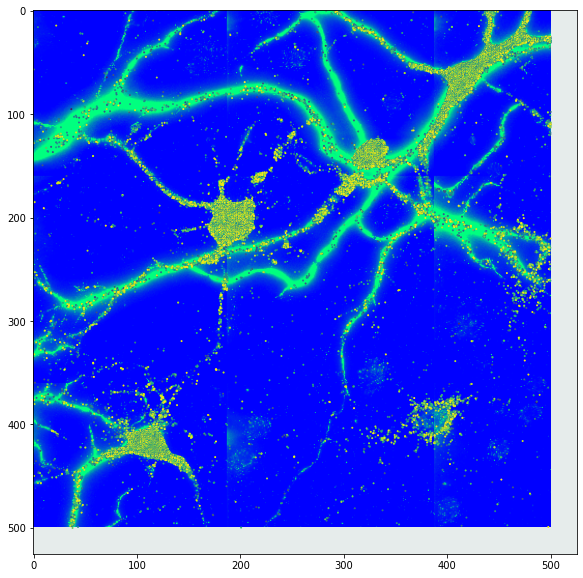

(4, 4)


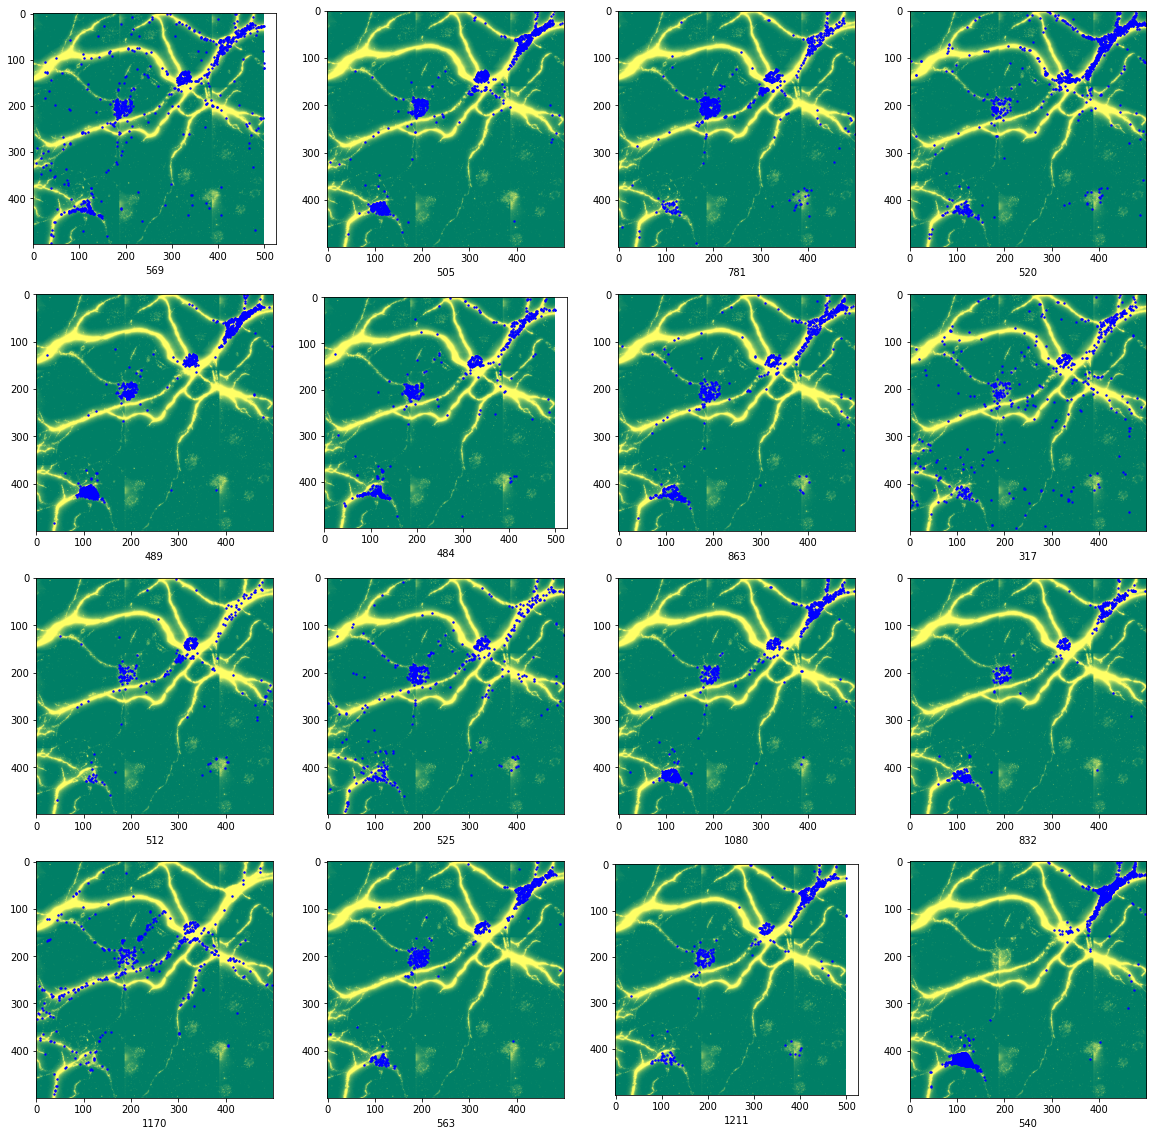

In [76]:
rec = trees.Rect([250, 1024, 500, 500])
bgimage = np.array(cv2.imread(datapath+"Map2TauImage.png")[rec.y:rec.y+rec.h, rec.x:rec.x+rec.w])
# bgimage[:,:,0:2] = 255 - bgimage[:,:,2:3]
# bgimage[:,:,2] = 255
facecolor = '#e6eceb'
# #
# bgimage = processImage[rec.y:rec.y+rec.h, rec.x:rec.x+rec.w]

fig = plt.figure(figsize=(10,10))
ax = plt.subplot()
# qtree.draw(ax, rec)
# this_rna = qtree.query(rec)
# this_rcvs = get_rcvs(this_rna, 200, qtree)
# normed_rcvs = embed_rcv(this_rcvs, pca, reducer, embedded)
# plot_points(ax, this_rna, c=(normed_rcvs+1)/2)
ax.set_facecolor('#e6eceb')
points = qtree.query(rec)
basicrna.plot_points(ax, points, colorizer=basicrna.ColorByBarcode(), image=bgimage[:,:,2], offset=(rec.y, rec.x), cmap="winter")

plt.show()


nrows = 4
ncols = 4
fig, axes = plt.subplots(nrows,ncols,figsize=(20,20))
print(axes.shape)
for i in range(nrows*ncols):
    tester = trees.BarcodeTester(max_codes[i])
    ax = axes[i//ncols][i%ncols]
    points = qtree.query(rec, tester=tester)
    basicrna.plot_points(ax, points, c='blue', s=2, image=bgimage[:,:,2], offset=(rec.y, rec.x), cmap="summer")
    ax.set_xlabel(f'{max_codes[i]}')

# group = PointExplorer(qtree)
# searcher = NearestNeighborSearch(qtree, 10, 5)
# adder = AddMethod()
# group.start_point(np.random.choice(qtree.query(rec)))
# group.expand(searcher, adder)
# plot_points(ax, group.accepted, c='b', offset=(rec.y, rec.x))

plt.show()

In [64]:
import importlib
importlib.reload(basicrna)

<module 'basicrna' from 'C:\\Lab Work\\segmentation\\Segmentation\\basicrna.py'>

### Build process and soma objects

In [12]:
processes = branches.buildProcesses(processImage, RNA)
somas = branches.buildSomas(somaImage, RNA)

100%|██████████| 142/142 [00:01<00:00, 99.56it/s] 


In [13]:
bbs = [[300,1000,500,500],[2500,2700,500,500]]

baseimgfile = datapath+"preprocessed.png"
baseimg = cv2.imread(baseimgfile)

probimname = 'preprocessed_Probabilities.png'
datafile = datapath + probimname
segProbIm = cv2.imread(datafile)

# plotting.embedimg(baseimg, bbs, plotpath)
# plotting.embedimg(segProbIm, bbs, datapath, name="probabilities")
# plotting.embedimg(processImage, bbs, datapath, name="processImg")

In [ ]:
for process in list(processes.values())[:20]:
    neighbors = process.getNeighbors(somaImage, 'soma', 10)

In [ ]:
branch_list = []
for process in list(processes.values())[:20]:
    for soma in process.neighbors['soma']:
        root = branches.Root(somas[soma])
        branch_list.append(branches.Branch(root, process))
branch_list[4].plot()

In [ ]:
plotting.implot(branch_list[4].disIm)

In [ ]:
for i, branch in enumerate(branch_list[:5]):
    rnaids, rnadists = branch.get_rnadistances(True)
    # plotting.plotKDE(rnadists, "RNA distribution along candidate branch", savefile=datapath+f'rnabranch{i}.png')

In [ ]:
for branch in branch_list[:5]:
    process = branch.end
    soma = branch.source.end
    # print(process.ymin, process.xmin, process.label, process.neighbors)
    # print(soma.ymin, soma.xmin, soma.label)
    # plotting.implot(1*(processImage[branch.ymin:branch.ymax,branch.xmin:branch.xmax]==process.label) + (somaImage[branch.ymin:branch.ymax,branch.xmin:branch.xmax]==soma.label)*2, datapath, show=False)
    # plotting.implot((somaImage[branch.ymin:branch.ymax,branch.xmin:branch.xmax]==soma.label)*2, datapath, show=False)
    # plt.show()

In [ ]:
import pyro
import pyro.distributions as dist
import torch.distributions.constraints as constraints
import torch
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

branch = branch_list[4]

# clear the param store in case we're in a REPL
pyro.clear_param_store()

def model(data):
    # beta = dist.Uniform('beta',low=torch.tensor(0.0), high=torch.tensor(1.0))
    # sigma = dist.Bernoulli('sigma',p=beta)
    lam_0 = pyro.sample('latent_rate', dist.Beta(torch.tensor([1.0]),torch.tensor([1.0])))
    # x = dist.Uniform('x',np.min(branch.rnadists),np.max(branch.rnadists))
    for i in range(len(data)):
        x = pyro.sample(f'distance_{i}', dist.Exponential(lam_0), obs=data[i])

def guide(data):
    alpha_q = pyro.param("alpha_q", torch.tensor([1.0]), constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor([1.0]), constraint=constraints.positive)
    pyro.sample("latent_rate", dist.Beta(alpha_q,beta_q))

# setup the optimizer
adam_params = {"lr": 0.05, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

data = torch.from_numpy(branch.rnadists)
n_steps = 200

# do gradient steps
for step in range(n_steps):
    svi.step(data)
    if step % 20 == 0:
        alpha = pyro.param("alpha_q").item()
        beta = pyro.param("beta_q").item()
        inferred_mean = alpha / (alpha + beta)
        print(step, inferred_mean)

In [ ]:
alpha = pyro.param("alpha_q").item()
beta = pyro.param("beta_q").item()
inferred_mean = alpha / (alpha + beta)
print(1/inferred_mean)

In [ ]:
print(alpha,beta)

In [ ]:
import seaborn as sns

In [ ]:
rate_dist = dist.Beta(alpha,beta)
x = torch.tensor(np.arange(0.01,0.1,0.001))
plt.plot(x,np.exp(rate_dist.log_prob(x)))
plt.ylabel("P(lam|data)")
plt.xlabel("lam")
plt.title("Posterior Distribution of Rate Parameter")
plt.show()
x = torch.tensor(np.arange(1,220,1))
plt.plot(x,np.exp(dist.Exponential(inferred_mean).log_prob(x)),label="P(x|lamda)")
plt.plot(x,np.exp(dist.Exponential(1/np.mean(branch.rnadists)).log_prob(x)),label="MLE P(x|lamda)")
sns.kdeplot(branch.rnadists, label="True distribution",bw_method=0.02)
plt.xlabel("distance from soma (px)")
plt.title("Exponential Fit to Data")
plt.legend()
plt.xlim(xmin=0)
plt.show()

In [ ]:
# import pyro
# import pyro.distributions as dist
# import pyro.poutine as poutine
# from pyro.infer import MCMC, NUTS
#
# # pyro.set_rng_seed(0)
# pyro.clear_param_store()
#
# def model(data):
#     beta = pyro.param('prob_above',torch.tensor([0.5]),constraint=constraints.interval(0,1))
#     sigma = pyro.sample('bool_above', dist.Bernoulli(beta))
#
#     lam = pyro.param('latent_rate',torch.tensor([0.5]),constraint=constraints.positive)
#     delta = pyro.param('delta', dist.Exponential(lam))
#     x = pyro.sample("source", dist.Uniform(torch.tensor(data.min()),torch.tensor(data.max())))
#
#     position = (2*sigma - 1)*delta + x
#
#     i = np.random.randint(len(data))
#     pyro.sample('obs', dist.Normal(position, 0.05), obs=data[i])
#
# # def conditioned_model(model, sigma, y):
# #     return poutine.condition(model, data={"obs": y})(sigma)
#
# nuts_kernel = NUTS(model)
# mcmc = MCMC(
#     nuts_kernel,
#     num_samples=1000,
#     num_chains=1,
# )
#
# data = torch.from_numpy(branch.rnadists)
#
# mcmc.run(data)
# mcmc.summary(prob=0.5)